In [1]:
%matplotlib notebook
from pykat import finesse
from pykat.commands import *
import pykat.external.peakdetect as peak
import pykat.ifo.aligo as aligo
import pykat.ifo.aligo.plot as aligoplt
#import pykat
import gwinc as gwinc

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import pykat
import importlib
importlib.reload(pykat)
pykat.init_pykat_plotting(dpi=96)
import pykat.ifo as ifo
#for animations:
from matplotlib import animation, rc
from IPython.display import HTML
plt.style.use('dark_background')
# Update the matplotlib configuration parameters:
plt.rcParams.update({'text.usetex': False,
                     'lines.linewidth': 2,
                     #'font.family': 'serif',
                     #'font.serif': 'noto',
                     'font.size': 11,
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small',
                     'axes.labelsize': 'medium',
                     'axes.titlesize': 'medium',
                     'axes.grid.axis': 'both',
                     'axes.grid.which': 'both',
                     'axes.grid': True,
                     'grid.color': 'xkcd:gray',
                     'grid.alpha': 0.3,
                     'lines.markersize': 12,
                     'legend.borderpad': 0.2,
                     'legend.fancybox': True,
                     'legend.fontsize': 'small',
                     'legend.framealpha': 0.8,
                     'legend.handletextpad': 0.5,
                     'legend.labelspacing': 0.33,
                     'legend.loc': 'best',
                     'figure.figsize': ((7, 4)),
                     'savefig.dpi': 300,
                     'savefig.bbox': 'tight',
                     'pdf.compression': 9})


def radar_plot(self, detector_I, detector_Q, DOFs=None, ax=None, title=None, leg=True, autoscale=True):
    """Generates an I-Q quadrature radar plot from this sensing matrix.
    
    Each radar plot shows the magnitude and phase of the response in that
    sensor for each of the DOFs. e.g. Watts in POP_f1 per meter of ETMX motion
                    
    Parameters
    ----------
    detector_I : str
        Detector name in the sensing matrix for I quadrature
        
    detector_Q : str
        Detector name in the sensing matrix for Q quadrature
        
    DOFs : collection[str], optional
        DOFs in the sensing matrix to plot
    
    ax : axis, optional
        Matplotlib axis to put plot into
        
    title: str, optional
        Title of plot
    """
    
    I = self[detector_I]
    Q = self[detector_Q]
    
    A = I + 1j*Q
    
    # FFS, we need to standardize on the colors for the DOFs with an iron fist
    # DARM = DODGER BLUE, CARM = CARNATION, PRCL=PURPLE, MICH = MIDNIGHT, SRCL = Cyan
    clrs = ['xkcd:Dodger Blue', 'xkcd:Red', 'xkcd:Lavender', 'xkcd:Cyan', 'xkcd:Grey']
    
    _ax = ax or plt.subplot(111, projection='polar')
    _ax.set_theta_zero_location('E')
    r_lim = (np.log10(np.abs(A)).min()-1, np.log10(np.abs(A)).max())
    
    if DOFs and any((_ not in A.keys() for _ in DOFs)):
        raise Exception("Sensing matrix is missing one of DOFs ({0}) requested".format(DOFs))
        
    if DOFs:
        keys = tuple(_ for _ in A.keys() if _ in DOFs)
    else:
        keys = A.keys()
        
    scaling = np.linspace(7, 4, len(keys))
    
    for _, s, cc in zip(keys, scaling, clrs):
        theta = np.angle(A[_])
        r     = np.log10(np.abs(A[_]))
        _ax.plot((theta,theta), (r_lim[0], r), lw=s, label=_, alpha=0.6, color=cc)
    ttl = _ax.set_title(title, fontsize=11)
    ttl.set_position([.5, 1.12])
    
    if autoscale == True:
        _ax.set_ylim(r_lim[0], r_lim[1])
    else:
        _ax.set_ylim(6, 11)
    
    if leg==True:
        _ax.legend(bbox_to_anchor=(0.5, -0.1), ncol=5)
    
    _ax.set_rticks(np.arange(*np.round(r_lim)))
    _ax.set_yticklabels(tuple( "$10^{%s}$" % _ for _ in np.arange(*np.round(r_lim), dtype=int)))
    _ax.grid(True, zorder = -10, lw = 2)
    if ax is None:
        plt.tight_layout()
        plt.show()
        
def prettySensingMatrix(self, cmap = 'jet'):
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
    # Set colormap equal to seaborns light green color palette
    cmap = plt.get_cmap(cmap)

    # Set CSS properties for th elements in dataframe
    th_props = [
      ('font-size', '24'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', 'xkcd:White'),
      ('background-color', 'xkcd:Black')
      ]

    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '24')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]
        
    self = (self.style
      .background_gradient(cmap=cmap, subset=list(self))
      .set_caption('Interferometer Sensing Matrix')
      .format("{:0.3g}")
      .set_table_styles(styles))
    
    return self

                                              ..-
    PyKat 1.2.2           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [24]:
#Optical layout for Power Recycled Michealson Interferometer (PRMI)
basecode = """
#EOM frequency constant
const f1 9M
const f2 45M

#Space between PRM and BS
const lp 1

#Space between BS and ETMX
const lx 1000

#Space between BS and ETMY
const ly 1000

l laser 1 0 n0                          #Laser power = 1W offset = 0                     
s s_laser 1 n0 neom1_1                  #Space between Laser and EOM = 1m        
mod eom1 $f1 0.45 1 pm neom1_1 neom1_2  #EOM modulation index = 0.45 
s s_eom1 1 neom1_2 neom2_1              #Space between EOM1 and EOM2
mod eom2 $f2 0.0 1 pm neom2_1 neom2_2  #EOM PM modulation index = 0.45
s s_eom2 1 neom2_2 nprm1                #Space between EOM2 and PRM
m PRM 0.98 0.01 0 nprm1 nprm2           #PRM Mirror R = 0.98 T = 0.01
s sprm $lp nprm2 nbs1                   # Space between prm and bs 
bs bs1 0.5 0.5 0 45 nbs1 nbs2 nbs3 nbs4 # Beam Splitter R = 0.5, T = 0.5, phi = 0,  
s sy $ly nbs2 nETMY1                    # Space BS and Mirror Y 
m1 ETMY 5e-06 3.75e-05 0 nETMY1 dump    # Mirror Y 
s sx $lx nbs3 nETMX1                    # Space BS and Mirror X (Length Lx = 1000m)
m1 ETMX 5e-06 3.75e-05 90 nETMX1 dump   # Mirror X
"""
basekat = finesse.kat()
basekat.verbose = False
basekat.parse(basecode,
              keepComments = False, 
              preserveConstants = True)

# Create IFO object
basekat.IFO = ifo.IFO(basekat,   #kat object 
                      ['phase'], #list of tuning keys (ex. phase for mirrors)
                      ['PRM', 'ETMX', 'ETMY'])  #list of tuning components 

basekat.IFO.f1 = float(basekat.eom1.f)   # Modulation Freqency
basekat.IFO.f2 = float(basekat.eom2.f)   # Modulation Freqency


# Create Output objects (Ports)
#Reflection from PRMI
basekat.IFO.REFL9 = ifo.Output(IFO= basekat.IFO,#The output referred to ifo obj
                              name= "REFL9",    #Name of the photodiode to appear in kat file
                              nodeNames="nprm1",  #Node to which detector is connected
                              f_property_name="f1",#Name of the frequency attribute 
                              phase = 0)    #Phase of "I" of the detector
#Pick-off Port ligth from BS back to PRM
basekat.IFO.POP9 = ifo.Output(IFO= basekat.IFO,#The output referred to ifo obj
                              name= "POP9",    #Name of the photodiode to appear in kat file
                              nodeNames="nbs1",  #Node to which detector is connected
                              f_property_name="f1",#Name of the frequency attribute 
                              phase = 0)    #Phase of "I" of the detector
#Asymmetric Port 
basekat.IFO.AS9 = ifo.Output(IFO= basekat.IFO,#The output referred to ifo obj
                              name= "AS9",    #Name of the photodiode to appear in kat file
                              nodeNames="nbs4",  #Node to which detector is connected
                              f_property_name="f1",#Name of the frequency attribute 
                              phase = 0)    #Phase of "I" of the detector
#Reflection from PRMI
basekat.IFO.REFL45 = ifo.Output(IFO= basekat.IFO,#The output referred to ifo obj
                              name= "REFL45",    #Name of the photodiode to appear in kat file
                              nodeNames="nprm1",  #Node to which detector is connected
                              f_property_name="f1",#Name of the frequency attribute 
                              phase = 0)    #Phase of "I" of the detector
#Pick-off Port ligth from BS back to PRM
basekat.IFO.POP945 = ifo.Output(IFO= basekat.IFO,#The output referred to ifo obj
                              name= "POP45",    #Name of the photodiode to appear in kat file
                              nodeNames="nbs1",  #Node to which detector is connected
                              f_property_name="f1",#Name of the frequency attribute 
                              phase = 0)    #Phase of "I" of the detector
#Asymmetric Port 
basekat.IFO.AS45 = ifo.Output(IFO= basekat.IFO,#The output referred to ifo obj
                              name= "AS45",    #Name of the photodiode to appear in kat file
                              nodeNames="nbs4",  #Node to which detector is connected
                              f_property_name="f1",#Name of the frequency attribute 
                              phase = 0)    #Phase of "I" of the detector

# Create Degree Of Freedom
basekat.IFO.DARM = ifo.DOF(IFO = basekat.IFO, #This DOF referes to ifo obj
                              _DOFName="DARM",#Name of the DOF
                              _port= basekat.IFO.AS9,#Output from which signal is extracted
                              _quad="Q",    #quadrature of the signal "I", "Q", "" 
                                            #for DC
                              _optics=["ETMX", "ETMY"],#List of the optics that will move as per
                                             #defined DOF.
                              _factors=[1,-1],  #list of factors in which optics will be moved
                              _scale=1,      #Scaling
                              sigtype="z")   #Signal type
basekat.IFO.CARM = ifo.DOF(IFO = basekat.IFO, #This DOF referes to ifo obj
                              _DOFName="CARM",#Name of the DOF
                              _port= basekat.IFO.REFL9,#Output from which signal is extracted
                              _quad="I",    #quadrature of the signal "I", "Q", "" 
                                            #for DC
                              _optics=["ETMX", "ETMY"],#List of the optics that will move as per
                                             #defined DOF.
                              _factors=[1,-1],  #list of factors in which optics will be moved
                              _scale=1,      #Scaling
                              sigtype="z")   #Signal type


basekat.IFO.update()

The following commands are parsed
var scan 0
set scanre scan re
xaxis scan re lin -90 90 200
func scETMX = (1) * (1) * $scanre
noplot scETMX
put* ETMX phi $scETMX
func scETMY = (1) * (-1) * $scanre
noplot scETMY
put* ETMY phi $scETMY

The following commands are parsed
['pd1 AS9_Q 9000000.0 90.0 nbs4']
# Kat Code Starts##############################
% Generated by PyKat 16.06.2020 22:14:09

const f1 9000000.0
const f2 45000000.0
const lp 1.0
const lx 1000.0
const ly 1000.0
l laser 1.0 0.0 0.0 n0
s s_laser 1.0 n0 neom1_1
mod eom1 $f1 0.45 1 pm 0.0 neom1_1 neom1_2
s s_eom1 1.0 neom1_2 neom2_1
mod eom2 $f2 0.0 1 pm 0.0 neom2_1 neom2_2
s s_eom2 1.0 neom2_2 nprm1
m PRM 0.98 0.01 0.0 nprm1 nprm2
s sprm $lp nprm2 nbs1
bs bs1 0.5 0.5 0.0 45.0 nbs1 nbs2 nbs3 nbs4
s sy $ly nbs2 nETMY1
m1 ETMY 5e-06 3.75e-05 0.0 nETMY1 dump
s sx $lx nbs3 nETMX1
m1 ETMX 5e-06 3.75e-05 90.0 nETMX1 dump
var scan 0.0
set scanre scan re
xaxis scan re lin -90 90 200
noplot scETMX
func scETMX = (1) * (1) * $scanre
put* E

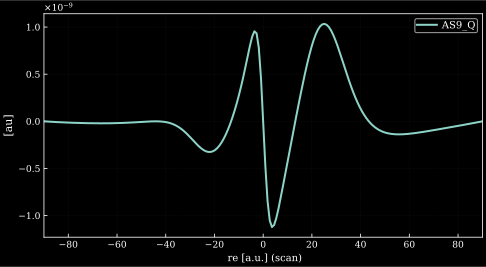

In [25]:

out = basekat.IFO.DARM.scan(xlimits = [-90,90], #finesse xaxis command min and max 
                               steps = 200,          #finesse xaxis steps
                               relative = True,      #Add "*" to "put" commands in Finesse
                               extra_cmds = None)   
out.plot()

#### Operating Point 1. Carrier is resonant
define function which takes Lprc as input and returns sensitivity at optimized demod phase n 